<a href="https://colab.research.google.com/github/Jieoi/traffic_sign_recognition/blob/main/model_training_RRDB_enhanced_data_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: This instance of Google Colab has been configured to use T4 GPU. It is possible to run all other sections at a slower rate on CPU.

Note: The code below has been configured to run on Google colab with python scripts and data imported from google drive. Please download the scripts and data from [here](https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8). Files required including all scripts and helper files under data_preparation folder and data_augmentation folder. Alternatively, vist my github repository to [download](https://github.com/Jieoi/traffic_sign_recognition/tree/main) the scripts and helper files.

<h1> 2.1 Data Preparation for Machine Learning</h1>

<h2>2.1.1 Preparing the notebook</h2>

The first step is to connect to Google Drive so that the data enhanced in the previouse notebook can be used.

The exact files that the notebook needs to  access are <code>final_image.zip</code> and <code>image_data.csv</code>. It can be found in the link <a href="https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8">here</a>.

Ideally, the notebook should be run in Google Colab with high RAM and GPU support. However, the code can be excuted on CPU only mode with a longer training time.

In [1]:
# Checking GPU availability
!nvidia-smi

Mon Sep 11 07:33:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('drive', force_remount=True)

Mounted at drive


The libraries used in this notebook are listed below.

In [22]:
# Zip file handling
import zipfile
import os

# Data handling and visualization
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File handling and management for training and validation data
from shutil import copyfile
from sklearn.model_selection import train_test_split

# importing library for ML processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CNN layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Regularization
from tensorflow.keras import regularizers

# Saving the model
from tensorflow.keras.models import save_model

# Metrics for evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

<h2>2.1.2 Data preparation for Machine Learning</h2>

Firstly, pre-porcessed training data is obtained and prepared for machine learning:


The labels for all the images is in the <code>image_data.csv</code> file. It is first extracted in the code below.

Then the images are extracted from the <code>final_image.zip</code> file.

In [4]:
# Paths
zip_file_path = 'drive/MyDrive/final/train_data/image_enhanced_PIL_RRDB.zip'
extracted_dir = 'extracted_images'

# Create the directory for extracted images if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)


# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Check the length of the extracted images
num_extracted_images = len(os.listdir(extracted_dir))
print(f"Number of extracted images: {num_extracted_images}")
print("Extraction completed.")

Number of extracted images: 26660
Extraction completed.


In [5]:
# Define the directory where the images are extracted
extracted_dir = 'extracted_images'

# Get a list of all extracted image files
image_files = os.listdir(extracted_dir)

# Initialize lists to store image names and label numbers
image_names = []
label_numbers = []

# Loop through the image files and extract image names and label numbers
for image_file in image_files:
    if image_file.endswith('.png'):
        # Split the image file name to extract label number
        parts = image_file.split('_')
        if len(parts) >= 3:
            label_number = int(parts[-1].split('.')[0])  # Extract the label number
            image_names.append(image_file)
            label_numbers.append(label_number)

# Create a pandas DataFrame
data = {'filename': image_names, 'class': label_numbers}
df_classes = pd.DataFrame(data)

# Print the first few rows of the DataFrame
df_classes.head()

,filename,class
0,image_23125_label_30.png,30
1,image_887_label_3.png,3
2,image_1006_label_10.png,10
3,image_13641_label_12.png,12
4,image_14748_label_17.png,17


Both images and there labels extracted contains the same number of entries.

The distribution of the final classes is shown below.

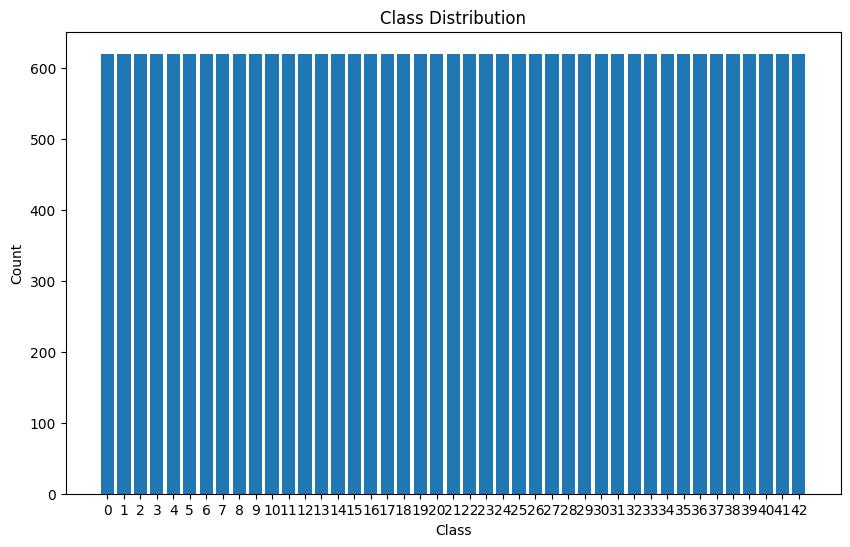

In [6]:
# Count the occurrences of each class in the DataFrame
class_counts = df_classes['class'].value_counts()

# Sort the unique class IDs
unique_classes = np.sort(df_classes['class'].unique())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts[unique_classes])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(unique_classes)
plt.show()

Both images are first split into training and validation sets. They are grouped by their classes and stored in individual directories for every classes.

In [7]:
train_dir = 'train_images'
valid_dir = 'valid_images'

# Create directories for training and validation images
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(df_classes, test_size=0.2, random_state=42, stratify=df_classes['class'])

# Copy images to directories based on classes for training set
for index, row in train_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(train_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

# Copy images to directories based on classes for validation set
for index, row in valid_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(valid_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

print("Data preparation for ML completed.")

Data preparation for ML completed.


<h1> 2.2 Machine Learning</h1>

<h2>2.2.1 Data pipeline</h2>

<code>flow_from_directory()</code> from Keras ImageDataGenerator is used to load the images with rescaling to 1/255. batch size and image size are pre-set to 32 and (128, 128), respectively.

In [8]:
# Define image dimensions and batch size
image_size = (128,128)
batch_size = 32

# Create data generators and rescale image for ML on training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Set shuffle to True for training data
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for validation data
)

# Get the number of classes from the training generator
num_classes = len(train_generator.class_indices)

Found 21328 images belonging to 43 classes.
Found 5332 images belonging to 43 classes.


Next, the test data is also obtained and prepared for machine learning.

In [9]:
# Define a function to extract the class label from the image file name
def extract_label(filename):
    parts = filename.split('_')
    if len(parts) >= 3:
        return parts[-2]  # Extract the label number
    else:
        return None

In [10]:
# Define the paths
test_zip_path = 'drive/MyDrive/final/test_data/test_images_enhanced_PIL_RRDB.zip'
test_extracted_dir = 'extracted_test_images'
test_dir = 'test_images'

# Create the directory for extracted test images if it doesn't exist
os.makedirs(test_extracted_dir, exist_ok=True)

# Open the ZIP file and extract its contents
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extracted_dir)

In [11]:
# List all files in the extracted directory
test_image_files = os.listdir(test_extracted_dir)

# Create subdirectories based on class labels and move images
for filename in test_image_files:
    if filename.endswith('.png'):
        label = extract_label(filename)
        if label is not None:
            class_dir = os.path.join(test_dir, label)
            os.makedirs(class_dir, exist_ok=True)
            src_path = os.path.join(test_extracted_dir, filename)
            dst_path = os.path.join(class_dir, filename)
            copyfile(src_path, dst_path) # shutil

In [12]:
# Create a data generator for the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for testing data
)

Found 12599 images belonging to 43 classes.


<h2>2.2.2 Training the CNN model</h2>

Double checking the GPU availability and set the GPU device if it is available

In [13]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Specify GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


A function is defined to plot the training history

In [14]:
def calculate_accuracy_increase_rate(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    train_rate = np.mean(np.diff(train_accuracy))
    val_rate = np.mean(np.diff(val_accuracy))

    return train_rate, val_rate

In [15]:
def plot_training_history(history):
    # Access the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the training and validation accuracy
    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the training and validation loss
    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

In [16]:
# Get true labels from the test generator
true_labels = test_generator.classes

# Get unique true labels
class_names = [str(label) for label in range(43)]

<h2> Model 1: Simple CNN baseline</h2>


In [18]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

Training the CNN model to upto 30 epochs, early stopping is used to prevent overfitting. However, no regularization is applied.

In [19]:
# Define the ResNet50 base model
input_layer = Input(shape=(128, 128, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

# Add custom head layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Apply Global Average Pooling to the 4D tensor
x = Dense(256, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Use num_classes

# Create the model
model_resnet = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [23]:
# Define a learning rate decay function
def lr_decay(epoch, lr):
    if epoch < 5:
        return lr  # Keep the initial learning rate for the first 5 epochs
    else:
        return lr * 0.95  # Decrease the learning rate by 5% after each epoch

# Scheduler callback for learning rate
lr_scheduler = LearningRateScheduler(lr_decay)

In [24]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 30
history_simpleRes = model_resnet.fit(train_generator,
                                     epochs=num_epochs,
                                     validation_data=valid_generator,
                                     callbacks=[early_stopping, lr_scheduler])

print("Model training completed.")

Epoch 1/30
667/667 [==============================] - 97s 145ms/step - loss: 0.0821 - accuracy: 0.9776 - val_loss: 0.0635 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 2/30
667/667 [==============================] - 94s 141ms/step - loss: 0.0183 - accuracy: 0.9955 - val_loss: 0.1105 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 3/30
667/667 [==============================] - 95s 142ms/step - loss: 0.0430 - accuracy: 0.9889 - val_loss: 0.0573 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 4/30
667/667 [==============================] - 94s 140ms/step - loss: 0.0138 - accuracy: 0.9966 - val_loss: 0.0999 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 5/30
667/667 [==============================] - 94s 142ms/step - loss: 0.0279 - accuracy: 0.9927 - val_loss: 0.3542 - val_accuracy: 0.9074 - lr: 0.0010
Epoch 6/30
667/667 [==============================] - 94s 142ms/step - loss: 0.0234 - accuracy: 0.9942 - val_loss: 0.0298 - val_accuracy: 0.9916 - lr: 9.5000e-04
Epoch 7/30
667/667 [============================

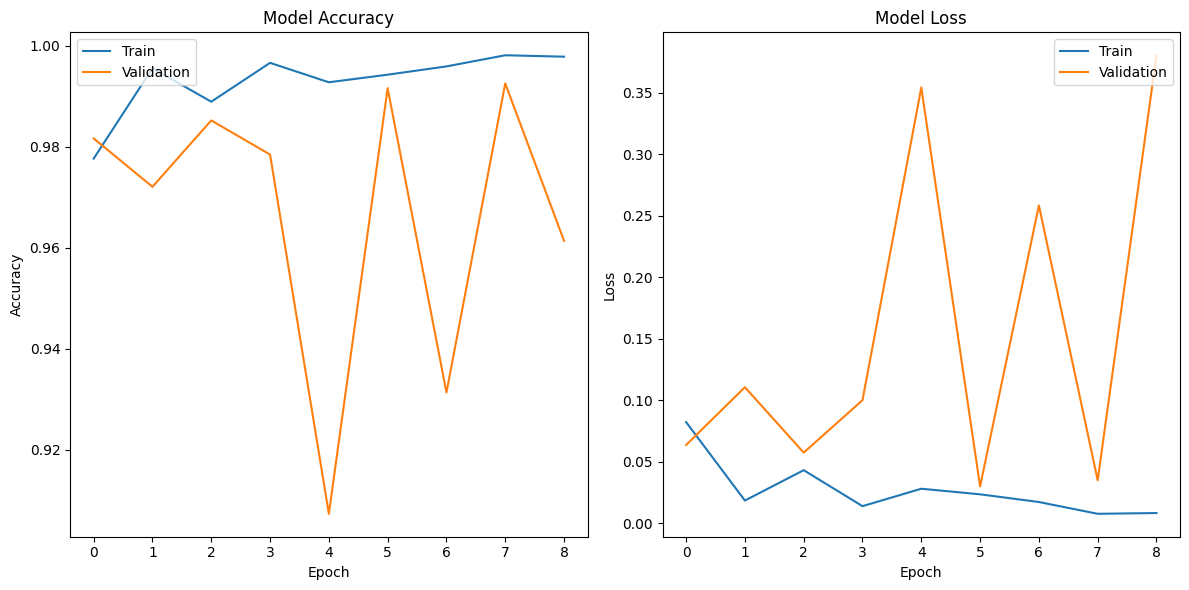

In [25]:
plot_training_history(history_simpleRes)

In [26]:
# Increasing rate
train_rate_res, val_rate_res = calculate_accuracy_increase_rate(history_simpleRes)
print("Training Accuracy Increase Rate:", train_rate_res)
print("Validation Accuracy Increase Rate:", val_rate_res)

Training Accuracy Increase Rate: 0.002520158886909485
Validation Accuracy Increase Rate: -0.002531886100769043


In [27]:
# Test the model with the test data
test_loss_res, test_accuracy_res = model_resnet.evaluate(test_generator)

print(f"Test Loss: {test_loss_res:.4f}")
print(f"Test Accuracy: {test_accuracy_res:.4f}")

394/394 [==============================] - 24s 60ms/step - loss: 0.2062 - accuracy: 0.9475
Test Loss: 0.2062
Test Accuracy: 0.9475


In [28]:
# Make predictions on the test data
test_pred_res = model_resnet.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
pred_labels_res = np.argmax(test_pred_res, axis=1)

# Calculate the precision score
precision_res = precision_score(true_labels, pred_labels_res, average='weighted')

print(f"Precision Score: {precision_res:.4f}")

394/394 [==============================] - 30s 74ms/step
Precision Score: 0.9504


In [29]:
# Generate a classification report
class_rep_res = classification_report(true_labels, pred_labels_res, target_names=class_names)

print("Classification Report:\n", class_rep_res)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94       293
           1       0.99      0.98      0.99       293
           2       0.98      0.97      0.98       293
           3       0.93      0.91      0.92       293
           4       1.00      0.87      0.93       293
           5       0.97      1.00      0.98       293
           6       0.98      1.00      0.99       293
           7       0.99      1.00      0.99       293
           8       0.99      0.98      0.99       293
           9       0.98      1.00      0.99       293
          10       1.00      0.92      0.96       293
          11       0.97      1.00      0.99       293
          12       0.96      1.00      0.98       293
          13       0.89      1.00      0.94       293
          14       0.97      0.88      0.92       293
          15       0.99      0.75      0.86       293
          16       0.94      0.94      0.94       293
   

<h2> Model 2: More complex CNN with regularization</h2>



More complexity is added to the CNN model with regularization added:

Added more convolutional layers with increasing filters to capture more complex features.
Added batch normalization layers after each convolutional and dense layer to help stabilize training.
Added an additional dense layer with dropout and batch normalization.

In [30]:
# Define the ResNet50 base model
input_layer = Input(shape=(128, 128, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

In [31]:
# Add custom head layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Apply Global Average Pooling to the 4D tensor
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Add L2 regularization
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(0.5)(x)  # Add Dropout for regularization
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Another dense layer with regularization
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Use num_classes

# Create the model
model_resnet_complex = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model_resnet_complex.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model_resnet_complex.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [33]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with data augmentation and early stopping
num_epochs = 50
history_complex_model = model_resnet_complex.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[early_stopping,  lr_scheduler])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 153s 146ms/step - loss: 2.0727 - accuracy: 0.5925 - val_loss: 3.1743 - val_accuracy: 0.4499 - lr: 0.0010
Epoch 2/50
667/667 [==============================] - 97s 145ms/step - loss: 0.6190 - accuracy: 0.9433 - val_loss: 0.5273 - val_accuracy: 0.9357 - lr: 0.0010
Epoch 3/50
667/667 [==============================] - 106s 159ms/step - loss: 0.4034 - accuracy: 0.9646 - val_loss: 0.4010 - val_accuracy: 0.9516 - lr: 0.0010
Epoch 4/50
667/667 [==============================] - 95s 143ms/step - loss: 0.3016 - accuracy: 0.9738 - val_loss: 0.4882 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 5/50
667/667 [==============================] - 106s 158ms/step - loss: 0.2665 - accuracy: 0.9772 - val_loss: 0.3440 - val_accuracy: 0.9522 - lr: 0.0010
Epoch 6/50
667/667 [==============================] - 95s 143ms/step - loss: 0.2396 - accuracy: 0.9803 - val_loss: 0.1724 - val_accuracy: 0.9908 - lr: 9.5000e-04
Epoch 7/50
667/667 [=========================

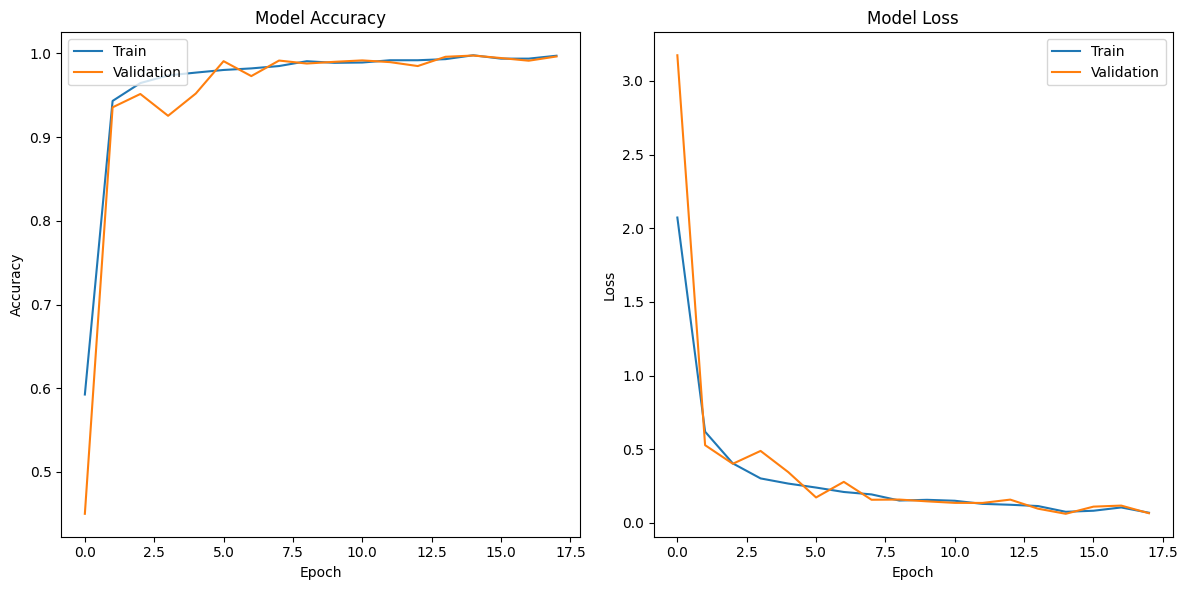

In [34]:
plot_training_history(history_complex_model)

In [35]:
# Increasing rate
train_rate_complex, val_rate_complex = calculate_accuracy_increase_rate(history_complex_model)
print("Training Accuracy Increase Rate:", train_rate_complex)
print("Validation Accuracy Increase Rate:", val_rate_complex)

Training Accuracy Increase Rate: 0.023815694977255428
Validation Accuracy Increase Rate: 0.032147742369595694


In [37]:
# Test the model with the test data
test_loss_complex, test_accuracy_complex = model_resnet_complex.evaluate(test_generator)

print(f"Test Loss: {test_loss_complex:.4f}")
print(f"Test Accuracy: {test_accuracy_complex:.4f}")

394/394 [==============================] - 24s 61ms/step - loss: 0.2914 - accuracy: 0.9600
Test Loss: 0.2914
Test Accuracy: 0.9600


In [38]:
# Make predictions on the test data
test_pred_complex = model_resnet_complex.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_complex = np.argmax(test_pred_complex, axis=1)

# Calculate the precision score
precision_complex = precision_score(true_labels, predicted_labels_complex, average='weighted')

print(f"Precision Score: {precision_complex:.4f}")

394/394 [==============================] - 26s 64ms/step
Precision Score: 0.9619


In [39]:
# Generate a classification report
class_rep_complex = classification_report(true_labels, predicted_labels_complex, target_names=class_names)

print("Classification Report:\n", class_rep_complex)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       293
           1       0.95      1.00      0.98       293
           2       1.00      0.98      0.99       293
           3       0.80      0.99      0.89       293
           4       1.00      0.97      0.98       293
           5       0.98      1.00      0.99       293
           6       0.99      1.00      0.99       293
           7       1.00      0.98      0.99       293
           8       1.00      1.00      1.00       293
           9       1.00      0.94      0.97       293
          10       0.97      0.95      0.96       293
          11       0.84      1.00      0.91       293
          12       0.96      0.99      0.98       293
          13       0.92      1.00      0.96       293
          14       0.93      1.00      0.96       293
          15       1.00      0.90      0.95       293
          16       0.89      0.99      0.93       293
   

<h2> Model 3: Even more complex CNN with regularization and more layers</h2>

In [71]:
# Define the ResNet50 base model
input_layer = Input(shape=(128, 128, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

In [72]:
# Add custom head layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Apply Global Average Pooling to the 4D tensor
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Add L2 regularization
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(0.5)(x)  # Add Dropout for regularization
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Another dense layer with regularization
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Use num_classes

# Create a new model with the custom head
model_unfrez = Model(inputs=base_model.input, outputs=output_layer)

In [73]:
# Freeze the earlier layers and fine-tune the later layers
for layer in base_model.layers[:-200]:
    layer.trainable = False

In [74]:
model_unfrez.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [75]:
# Compile the model with a lower learning rate for fine-tuning
model_unfrez.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fine-tune the model on your dataset
num_epochs = 50
history_unfrez = model_unfrez.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[early_stopping, lr_scheduler])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 135s 144ms/step - loss: 2.2739 - accuracy: 0.6116 - val_loss: 2.1179 - val_accuracy: 0.6459 - lr: 1.0000e-04
Epoch 2/50
667/667 [==============================] - 94s 141ms/step - loss: 0.8432 - accuracy: 0.9679 - val_loss: 0.6483 - val_accuracy: 0.9880 - lr: 1.0000e-04
Epoch 3/50
667/667 [==============================] - 94s 141ms/step - loss: 0.6876 - accuracy: 0.9889 - val_loss: 0.6102 - val_accuracy: 0.9908 - lr: 1.0000e-04
Epoch 4/50
667/667 [==============================] - 95s 142ms/step - loss: 0.6324 - accuracy: 0.9903 - val_loss: 0.6152 - val_accuracy: 0.9809 - lr: 1.0000e-04
Epoch 5/50
667/667 [==============================] - 94s 141ms/step - loss: 0.5677 - accuracy: 0.9935 - val_loss: 0.5041 - val_accuracy: 0.9961 - lr: 1.0000e-04
Epoch 6/50
667/667 [==============================] - 94s 141ms/step - loss: 0.5255 - accuracy: 0.9925 - val_loss: 0.4834 - val_accuracy: 0.9906 - lr: 9.5000e-05
Epoch 7/50
667/667 [=======

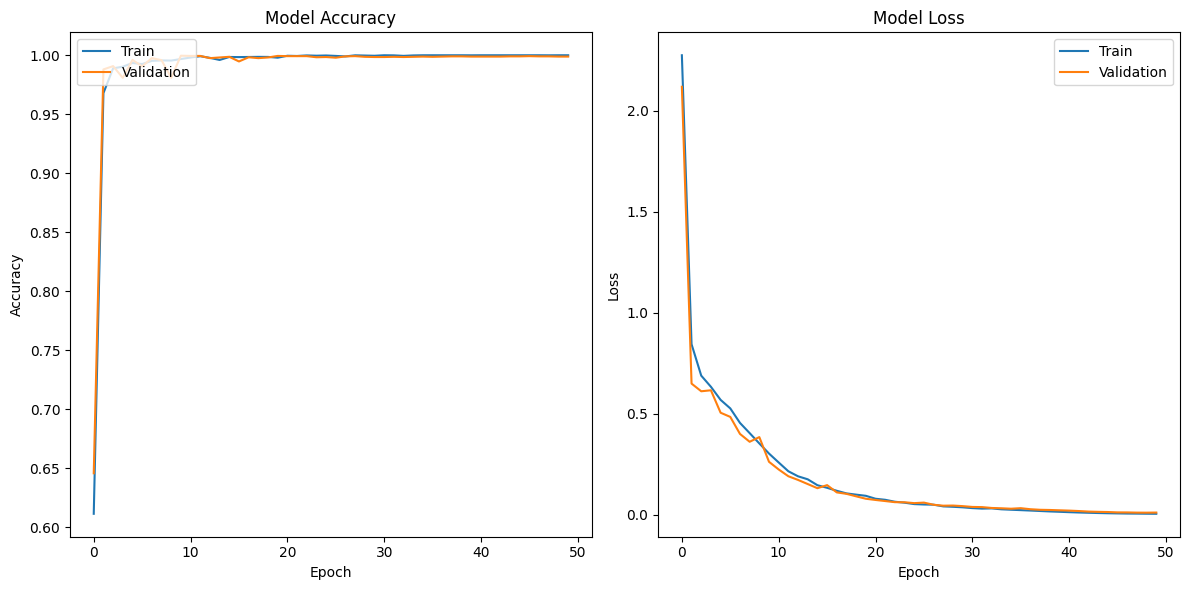

In [76]:
plot_training_history(history_unfrez)

In [77]:
# Increasing rate
train_rate_unfrez, val_rate_unfrez = calculate_accuracy_increase_rate(history_unfrez)
print("Training Accuracy Increase Rate:", train_rate_unfrez)
print("Validation Accuracy Increase Rate:", val_rate_unfrez)

Training Accuracy Increase Rate: 0.007926726827816087
Validation Accuracy Increase Rate: 0.007203332015446254


In [78]:
# Test the model with the test data
test_loss_unfrez, test_accuracy_unfrez = model_unfrez.evaluate(test_generator)

print(f"Test Loss: {test_loss_unfrez:.4f}")
print(f"Test Accuracy: {test_accuracy_unfrez:.4f}")

394/394 [==============================] - 22s 55ms/step - loss: 0.1173 - accuracy: 0.9848
Test Loss: 0.1173
Test Accuracy: 0.9848


In [79]:
# Make predictions on the test data
test_pred_unfrez = model_unfrez.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_unfrez = np.argmax(test_pred_unfrez, axis=1)

# Calculate the precision score
precision_unfrez = precision_score(true_labels, predicted_labels_unfrez, average='weighted')

print(f"Precision Score: {precision_unfrez:.4f}")

394/394 [==============================] - 22s 53ms/step
Precision Score: 0.9853


In [80]:
# Generate a classification report
class_rep_unfrez = classification_report(true_labels, predicted_labels_unfrez, target_names=class_names)

print("Classification Report:\n", class_rep_unfrez)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       0.99      1.00      0.99       293
           2       1.00      1.00      1.00       293
           3       0.96      1.00      0.98       293
           4       1.00      1.00      1.00       293
           5       1.00      1.00      1.00       293
           6       1.00      1.00      1.00       293
           7       1.00      0.99      1.00       293
           8       1.00      1.00      1.00       293
           9       1.00      1.00      1.00       293
          10       1.00      0.99      0.99       293
          11       1.00      1.00      1.00       293
          12       0.99      0.99      0.99       293
          13       0.99      1.00      0.99       293
          14       0.94      0.99      0.97       293
          15       0.96      0.97      0.96       293
          16       0.87      1.00      0.93       293
   

<h1> 2.3 Saving the model</h1>

In [89]:
# Define the file path where you want to save the raw predictions
save_path = "best_test_predictions_resnet50_RRDB.npy"

# Save the raw predictions to the specified file
np.save(save_path, test_pred_unfrez)

print(f"Raw predictions saved to '{save_path}'.")

Raw predictions saved to 'best_test_predictions_resnet50_RRDB.npy'.


In [90]:
model_unfrez.save("final_resnet_model_RRDB.keras")
model_unfrez.save("final_resnet_model_RRDB.h5")

In [91]:
def save_training_history(history, filename):
    # Create a DataFrame from the training history
    history_df = pd.DataFrame(history.history)

    # Save the DataFrame to a CSV file
    history_df.to_csv(filename, index=False)

    # Print the first few rows of the history DataFrame
    print(history_df.head())

In [92]:
save_training_history(history_simpleRes, 'training_history_simpleResnet_RRDB.csv')
save_training_history(history_complex_model, 'training_history_complexResnet_RRDB.csv')
save_training_history(history_unfrez, 'training_history_complexResnet_unfrez_RRDB.csv')

       loss  accuracy  val_loss  val_accuracy     lr
0  0.082094  0.977635  0.063468      0.981620  0.001
1  0.018311  0.995499  0.110460      0.972055  0.001
2  0.043014  0.988888  0.057296      0.985184  0.001
3  0.013753  0.996577  0.099889      0.978432  0.001
4  0.027920  0.992733  0.354178      0.907352  0.001
       loss  accuracy  val_loss  val_accuracy     lr
0  2.072691  0.592461  3.174296      0.449925  0.001
1  0.618958  0.943314  0.527289      0.935671  0.001
2  0.403378  0.964647  0.401002      0.951613  0.001
3  0.301585  0.973790  0.488225      0.925544  0.001
4  0.266479  0.977166  0.344047      0.952176  0.001
       loss  accuracy  val_loss  val_accuracy      lr
0  2.273927  0.611590  2.117903      0.645911  0.0001
1  0.843207  0.967929  0.648305      0.987997  0.0001
2  0.687609  0.988935  0.610247      0.990810  0.0001
3  0.632419  0.990294  0.615165      0.980870  0.0001
4  0.567670  0.993483  0.504084      0.996062  0.0001


In [93]:
import shutil
import os

# Define the destination directory in Google Drive
dest_dir = 'drive/MyDrive/final/training_models/resnet50/RRDB/'

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Define the source paths
src_paths = [
    'final_resnet_model_RRDB.keras',
    'final_resnet_model_RRDB.h5',
    'training_history_simpleResnet_RRDB.csv',
    'training_history_complexResnet_RRDB.csv',
    'training_history_complexResnet_unfrez_RRDB.csv',
    'best_test_predictions_resnet50_RRDB.npy'
]

# Copy files to Google Drive
for src_path in src_paths:
    shutil.copy(src_path, dest_dir)

print("Files copied to Google Drive successfully.")

Files copied to Google Drive successfully.
